In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
from pandas.tools.plotting import parallel_coordinates

from sklearn.cluster import KMeans

## Load Data:

In [2]:
# CLIMATE DAU 
partida_dau = pd.read_csv("dades/dades_csv/climatedau/game_partida.csv", delimiter=',' , encoding="latin-1")
ronda_dau = pd.read_csv("dades/dades_csv/climatedau/game_ronda.csv", delimiter=',' , encoding="latin-1")
user_dau = pd.read_csv("dades/dades_csv/climatedau/game_user.csv", delimiter=',' , encoding="latin-1")

user_dau.drop(user_dau.index[3], inplace=True)
userronda_dau = pd.read_csv("dades/dades_csv/climatedau/game_userronda.csv", delimiter=',' , encoding="latin-1")

eq_user_dau = pd.read_csv("dades/eq_user_dau.csv", delimiter=',' , encoding="latin-1")
ineq_user_dau = user_dau[~user_dau.user_id.isin(eq_user_dau['user_id'])]

# CLIMATE STREET 
partida_street = pd.read_csv("dades/dades_csv/climatestreet/game_partida_street.csv", delimiter=',' , encoding="latin-1")
ronda_street = pd.read_csv("dades/dades_csv/climatestreet/game_ronda_street.csv", delimiter=',' , encoding="latin-1")
user_street = pd.read_csv("dades/dades_csv/climatestreet/game_user_street.csv", delimiter=',' , encoding="latin-1")
user_street.drop(user_street[user_street['diners_inicials']== 0].index, inplace=True)
userronda_street = pd.read_csv("dades/dades_csv/climatestreet/game_userronda_street.csv", delimiter=',' , encoding="latin-1")

# CLIMATE VIL
partida_vil = pd.read_csv("dades/dadesvil/partida.csv", delimiter=',' , encoding="latin-1")
ronda_vil = pd.read_csv("dades/dadesvil/ronda.csv", delimiter=',' , encoding="latin-1")
user_vil = pd.read_csv("dades/dadesvil/user.csv", delimiter=',' , encoding="latin-1")
user_vil.drop(user_vil[user_vil['diners_inicials']== 0].index, inplace=True)
userronda_vil = pd.read_csv("dades/dadesvil/userronda.csv", delimiter=',' , encoding="latin-1")

user_street.rename(columns={'id': 'user_id'}, inplace=True)
user_vil.rename(columns={'id': 'user_id'}, inplace=True)

In [3]:
def contribution_round(user, userronda, norm):
    tonorm = user[['user_id','diners_inicials']]
    tocontr = pd.merge(userronda,tonorm, on = 'user_id')
    #Normalization
    tocontr['selnorm'] = (tocontr['seleccio']/tocontr['diners_inicials'])*10
    rondes = np.arange(1,11)
    ronda_id = np.tile(rondes,len(np.unique(userronda['user_id']))) #324 users
    tocontr['ronda_id'] = ronda_id
    contr_round = pd.pivot(index = tocontr['user_id'], columns = tocontr['ronda_id'], values = tocontr[norm])
    return contr_round

In [4]:
# Normalized contributions per round
## DAU
contr_dau_norm = contribution_round(user_dau,userronda_dau, 'selnorm')
contr_dau = contribution_round(user_dau,userronda_dau, 'seleccio')

## DAU eq: 
eq_dau = pd.read_csv("dades/eq_dau.csv", delimiter=',' , encoding="latin-1")
eq_contr_dau = eq_dau.iloc[:,2:12]
eq_contr_dau = eq_contr_dau.set_index(eq_user_dau.user_id)
eq_contr_dau_norm = contr_dau_norm[contr_dau_norm.index.isin(eq_dau['user_id'])]

## DAU ineq:
ineq_dau = pd.read_csv("dades/ineq_dau.csv", delimiter=',' , encoding="latin-1")
ineq_contr_dau = ineq_dau.iloc[:,2:12]
ineq_contr_dau = ineq_contr_dau.set_index(ineq_user_dau.user_id)
ineq_contr_dau_norm = contr_dau_norm[contr_dau_norm.index.isin(ineq_dau['user_id'])]

## STREET
contr_street_norm = contribution_round(user_street,userronda_street, 'selnorm')
contr_street = contribution_round(user_street,userronda_street, 'seleccio')

## VIL
contr_vil_norm = contribution_round(user_vil,userronda_vil, 'selnorm')
contr_vil = contribution_round(user_vil,userronda_vil, 'seleccio')

In [10]:
## Datasets: Heterogeneous, Homogeneous, Heterogeneous norm, Homogeneous norm
ineq_contr_dau_2= ineq_contr_dau.assign(experiment='het_dau')
contr_street_2= contr_street.assign(experiment='street')
frames_het = [ineq_contr_dau_2, contr_street_2]
heterogeneous = pd.concat(frames_het)

eq_contr_dau_2= eq_contr_dau.assign(experiment='hom_dau')
contr_vil_2= contr_vil.assign(experiment='vil')
frames_hom = [eq_contr_dau_2, contr_vil_2]
homogeneous = pd.concat(frames_hom)

ineq_contr_dau_2= ineq_contr_dau_norm.assign(experiment='het_dau')
contr_street_2= contr_street_norm.assign(experiment='street')
frames_het = [ineq_contr_dau_2, contr_street_2]
heterogeneous_norm = pd.concat(frames_het)

eq_contr_dau_2= eq_contr_dau_norm.assign(experiment='hom_dau')
contr_vil_2= contr_vil_norm.assign(experiment='vil')
frames_hom = [eq_contr_dau_2, contr_vil_2]
homogeneous_norm = pd.concat(frames_hom)

### Maximum a-posteriori Dirichlet process mixtures:

What to Do When K-Means Clustering Fails: A Simple yet Principled Alternative Algorithm; Yordan P. Raykov, Alexis Boukouvalas, Fahd Baig, Max A. Little (2016) (http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0162259&type=printable). Still has a few citations but seems to cluster well dense data. Sklearn community seems to distrust this implementation as it is tested only with toy datasets. I found next implementation in http://www.maxlittle.net/software/

#### Heterogeneous: 

In [11]:
X = heterogeneous_norm.iloc[:,:10]
n_clusters=3
k_means = KMeans(n_clusters=n_clusters, random_state=0, n_init = 30).fit(X)
clustcoef_het = k_means.labels_
y = clustcoef_het
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X),index = X.index)

Iteration 1: K=8, E=-845.593879, dE=inf

Iteration 2: K=8, E=-1707.891435, dE=862.297556

Iteration 3: K=8, E=-1728.006886, dE=20.115451

Iteration 4: K=8, E=-1741.206011, dE=13.199125

Iteration 5: K=7, E=-1756.429016, dE=15.223005

Iteration 6: K=7, E=-1763.338297, dE=6.909281

Iteration 7: K=7, E=-1767.655197, dE=4.316900

Iteration 8: K=7, E=-1775.684385, dE=8.029188

Iteration 9: K=7, E=-1775.752584, dE=0.068199

Iteration 10: K=7, E=-1774.975182, dE=-0.777402

Iteration 11: K=7, E=-1774.975182, dE=0.000000



Text(0.5,1,'MAPDP objective function')

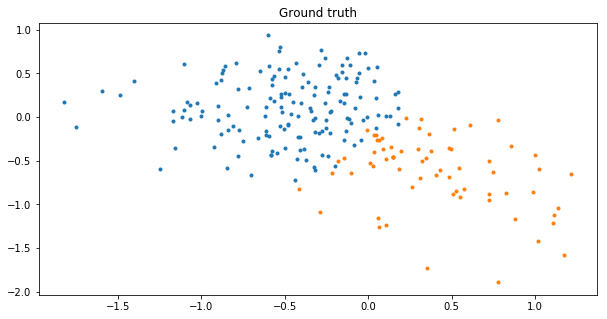

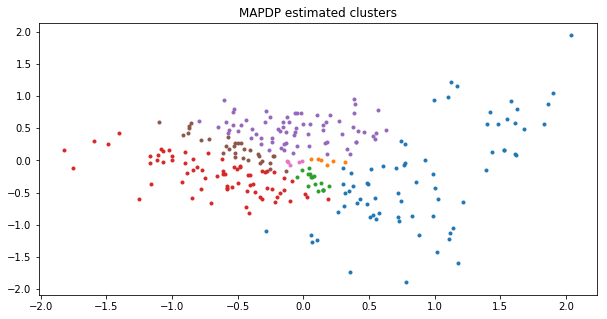

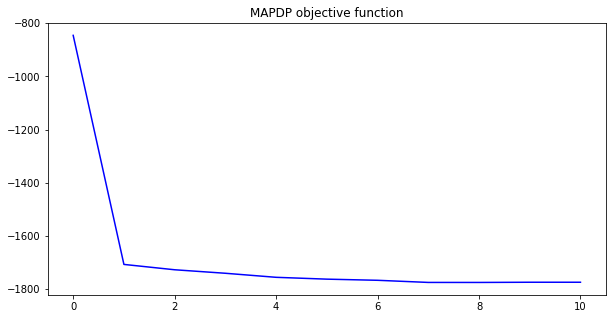

In [12]:

plt.ion()
import mapdp_nw as mapdp
# read in data
d = transformed
N = d.shape[0]
X = d.values.T
Z = y
# Set up Normal-Wishart MAP-DP prior parameters
N0 = 0.5            # Prior count (concentration parameter)
m0 = X.mean(1)[:, None]    # Normal-Wishart prior mean
a0 = 10             # Normal-Wishart prior scale
c0 = 10/float(N)    # Normal-Wishart prior degrees of freedom
B0 = np.diag(1/(0.05*X.var(1)))  # Normal-Wishart prior precision
# # Run MAPDP to convergence
mu, z, K, E = mapdp.mapdp_nw(X, N0, m0, a0, c0, B0)
# # Plotting
plt.figure(figsize=(10,5))
for j in range(1,K+1):
    i = (Z == j);
    plt.plot(X[0, i], X[1,i], '.')
plt.title('Ground truth')

plt.figure(figsize=(10,5))
for j in range(K):
    i = (z == j);
    plt.plot(X[0, i], X[1,i], '.')
plt.title('MAPDP estimated clusters')

plt.figure(figsize=(10,5))
plt.plot(E, '-b')
plt.title('MAPDP objective function')

#### Homogeneous:

In [13]:
X = homogeneous_norm.iloc[:,:10]
n_clusters=3
k_means = KMeans(n_clusters=n_clusters, random_state=0, n_init = 30).fit(X)
clustcoef_het = k_means.labels_
y = clustcoef_het
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X),index = X.index)

Iteration 1: K=8, E=-1184.604172, dE=inf

Iteration 2: K=8, E=-2755.368379, dE=1570.764207

Iteration 3: K=7, E=-2937.297342, dE=181.928963

Iteration 4: K=6, E=-3048.841090, dE=111.543748

Iteration 5: K=4, E=-3093.654860, dE=44.813769

Iteration 6: K=4, E=-3095.277004, dE=1.622144

Iteration 7: K=4, E=-3095.048259, dE=-0.228745

Iteration 8: K=4, E=-3095.048259, dE=0.000000



Text(0.5,1,'MAPDP objective function')

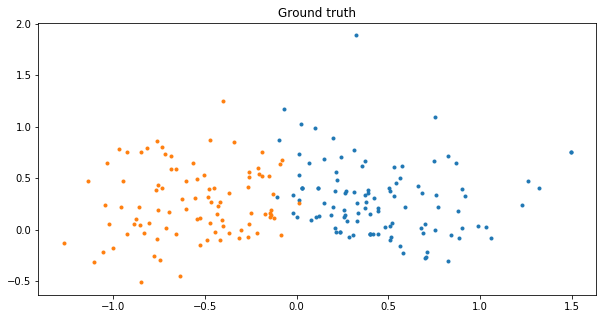

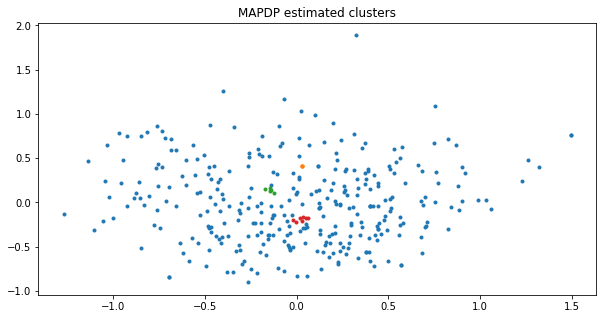

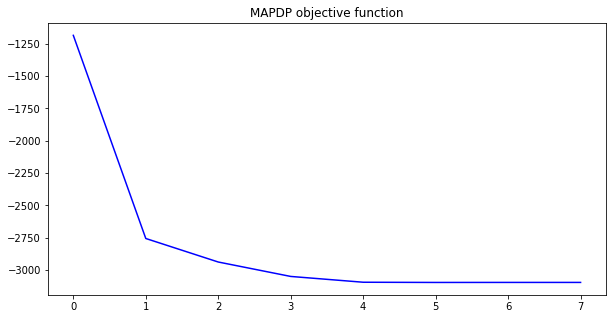

In [14]:

plt.ion()
import mapdp_nw as mapdp
# read in data
d = transformed
N = d.shape[0]
X = d.values.T
Z = y
# Set up Normal-Wishart MAP-DP prior parameters
N0 = 0.5            # Prior count (concentration parameter)
m0 = X.mean(1)[:, None]    # Normal-Wishart prior mean
a0 = 10             # Normal-Wishart prior scale
c0 = 10/float(N)    # Normal-Wishart prior degrees of freedom
B0 = np.diag(1/(0.05*X.var(1)))  # Normal-Wishart prior precision
# # Run MAPDP to convergence
mu, z, K, E = mapdp.mapdp_nw(X, N0, m0, a0, c0, B0)
# # Plotting
plt.figure(figsize=(10,5))
for j in range(1,K+1):
    i = (Z == j);
    plt.plot(X[0, i], X[1,i], '.')
plt.title('Ground truth')

plt.figure(figsize=(10,5))
for j in range(K):
    i = (z == j);
    plt.plot(X[0, i], X[1,i], '.')
plt.title('MAPDP estimated clusters')

plt.figure(figsize=(10,5))
plt.plot(E, '-b')
plt.title('MAPDP objective function')